# Music Genre Classification using CNN
## Objective
Aims to build a deep learning model that classifies music into genres using MFCC audio features extracted from the GTZAN and FMA datasets.

## Datasets Used

This project utilizes two publicly available datasets for training and evaluating a music genre classification model:

### GTZAN Genre Collection

- **Source:** [GTZAN Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)
- **Description:**  
  The GTZAN dataset contains 1,000 audio tracks, each 30 seconds long, equally distributed across **10 genres**:
  
  > *Blues, Classical, Country, Disco, Hiphop, Jazz, Metal, Pop, Reggae, Rock*
  
- **Format:** `.wav` audio files located in `genres_original/`, grouped by genre folders.
- **Usage in Project:**  
  MFCC features were extracted from each track. Data augmentation was applied (e.g., pitch shift, time stretch) to improve model generalization.

### FMA (Free Music Archive) – Small Subset

- **Source:** [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)
- **Description:**  
  The FMA small subset includes 8,000 audio clips (30 seconds each) from various genres. Metadata in CSV format provides track-level details including `genre_top`, `track_id`, etc.

- **Format:** `.mp3` files organized by ID-based subfolders. Metadata accessed via `tracks.csv`.
- **Usage in Project:**  
  Only tracks with top-level genres overlapping with GTZAN were selected. Audio was loaded, preprocessed, and MFCC features were extracted for classification.

*Both datasets helped improve the robustness and diversity of training samples, enabling better genre generalization across multiple music styles.*


## Import Required Libraries

In [28]:
import os
import librosa
import math
import numpy as np
import seaborn as sns
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.manifold import TSNE
from keras.saving import register_keras_serializable


## Constants

In [29]:
GTZAN_PATH = "../data/genres_original/"
FMA_PATH = "../data/fma_small/"
SAMPLES_PER_TRACK = 22050 * 30

## Utility Functions

In [30]:
def safe_load(file_path, sr=22050):
    try:
        signal, sr = librosa.load(file_path, sr=sr)
        if len(signal) == 0:
            raise ValueError("Empty signal.")
        return signal, sr
    except Exception as e:
        print(f"Skipping file {file_path}: {e}")
        return None, None

def normalize_genre(genre):
    if not isinstance(genre, str):
        return None
    genre = genre.lower()
    genre_map = {
        'hiphop': 'hip-hop', 'hip hop': 'hip-hop', 'hip-hop': 'hip-hop',
        'r&b': 'pop', 'pop rock': 'pop', 'disco': 'pop',
        'indie rock': 'rock', 'blues rock': 'rock',
        'electro': 'electronic', 'electronica': 'electronic',
        'metalcore': 'metal', 'rap': 'hip-hop'
    }
    return genre_map.get(genre, genre)

def augment_audio(signal, sr):
    # Randomly apply one of the augmentations
    choice = np.random.choice(["stretch", "pitch", "noise"])
    
    if choice == "stretch":
        rate = np.random.uniform(0.8, 1.2)
        return librosa.effects.time_stretch(y=signal, rate=rate)
    
    elif choice == "pitch":
        steps = np.random.randint(-2, 3)
        return librosa.effects.pitch_shift(y=signal, sr=sr, n_steps=steps)
    
    elif choice == "noise":
        noise_amp = 0.005 * np.random.uniform() * np.amax(signal)
        return signal + noise_amp * np.random.normal(size=signal.shape)
    return signal

## Feature Extraction

In [31]:
GENRES = [  # intersection of both datasets
    'blues', 'classical', 'country', 'disco', 'hiphop',
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]
genre_to_index = {genre: idx for idx, genre in enumerate(GENRES)}

# GTZAN Feature Extraction
def extract_features_gtzan(dataset_path, genres, 
                           n_mfcc=13, n_fft=2048, hop_length=512, 
                           duration=30, sample_rate=22050, 
                           segment_length=3, max_len=130):
    X, y = [], []

    def pad_or_truncate(mfcc, max_len):
        if mfcc.shape[0] < max_len:
            pad_width = max_len - mfcc.shape[0]
            return np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        else:
            return mfcc[:max_len, :]

    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        for file in os.listdir(genre_path):
            if file.endswith(".wav"):
                file_path = os.path.join(genre_path, file)
                signal, sr = librosa.load(file_path, sr=sample_rate, duration=duration)

                samples_per_segment = int(segment_length * sample_rate)
                num_segments = int(duration / segment_length)

                for s in range(num_segments):
                    start = s * samples_per_segment
                    end = start + samples_per_segment

                    if len(signal[start:end]) == samples_per_segment:
                        mfcc = librosa.feature.mfcc(y=signal[start:end],
                                                    sr=sr,
                                                    n_mfcc=n_mfcc,
                                                    n_fft=n_fft,
                                                    hop_length=hop_length).T
                        mfcc = pad_or_truncate(mfcc, max_len)
                        X.append(mfcc)
                        y.append(genre_to_index[genre])

    return np.array(X), np.array(y)

# FMA Feature Extraction
def extract_features_fma(metadata, audio_path, genres,
                         n_mfcc=13, n_fft=2048, hop_length=512,
                         duration=30, sample_rate=22050, segment_length=3):
    X, y = [], []
    num_segments = int(duration / segment_length)
    samples_per_segment = int(sample_rate * segment_length)
    expected_mfcc_len = math.ceil(samples_per_segment / hop_length)

    for _, row in metadata.iterrows():
        track_id = row["track_id"]
        genre = row["genre_top"]

        if genre not in genres:
            continue

        filename = f"{int(track_id):06d}.mp3"
        subfolder = filename[:3]
        filepath = os.path.join(audio_path, subfolder, filename)

        if not os.path.exists(filepath):
            continue

        try:
            signal, sr = librosa.load(filepath, sr=sample_rate, duration=duration)
            if len(signal) < sample_rate * duration:
                signal = np.pad(signal, (0, sample_rate * duration - len(signal)))

            for s in range(num_segments):
                start = s * samples_per_segment
                end = start + samples_per_segment
                mfcc = librosa.feature.mfcc(
                    y=signal[start:end], sr=sr,
                    n_mfcc=n_mfcc, n_fft=n_fft,
                    hop_length=hop_length
                ).T
                if mfcc.shape[0] < expected_mfcc_len:
                    mfcc = np.pad(mfcc, ((0, expected_mfcc_len - mfcc.shape[0]), (0, 0)))
                elif mfcc.shape[0] > expected_mfcc_len:
                    mfcc = mfcc[:expected_mfcc_len, :]

                X.append(mfcc)
                y.append(genre_to_index[genre])

        except Exception as e:
            print(f"Error processing {filepath}: {e}")

    return np.array(X), np.array(y)

# Combined Dataset Loader
def load_combined_dataset(gtzan_path, fma_metadata, fma_audio_path):
    X1, y1 = extract_features_gtzan(gtzan_path, GENRES)
    X2, y2 = extract_features_fma(fma_metadata, fma_audio_path, GENRES)
    X = np.concatenate((X1, X2), axis=0)
    y = np.concatenate((y1, y2), axis=0)
    X = X[..., np.newaxis]  # for CNN input shape
    return X, y

# Train-Test Split + Class Weights
def prepare_training_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))

    y_train_cat = to_categorical(y_train, num_classes=len(GENRES))
    y_test_cat = to_categorical(y_test, num_classes=len(GENRES))

    return X_train, X_test, y_train_cat, y_test_cat, class_weights_dict


## Dataset Merge & Preprocessing

In [32]:
# Setup paths and genre list
GENRES = sorted([d for d in os.listdir(GTZAN_PATH) if os.path.isdir(os.path.join(GTZAN_PATH, d))])

# Extract GTZAN features with labels
gtzan_X, gtzan_y = extract_features_gtzan(dataset_path=GTZAN_PATH, genres=GENRES)
gtzan_genres = [GENRES[y] for y in gtzan_y]

# Extract FMA features
FMA_METADATA = pd.read_csv("../data/fma_metadata/tracks.csv", index_col=0, header=[0, 1])
FMA_METADATA.columns = ['_'.join(col).strip() for col in FMA_METADATA.columns.values]
fma_info = FMA_METADATA[["track_genre_top"]].dropna()
fma_info = fma_info.reset_index().rename(columns={"track_genre_top": "genre_top", "index": "track_id"})

fma_X, fma_y = extract_features_fma(metadata=fma_info, audio_path=FMA_PATH, genres=GENRES)
fma_genres = [GENRES[y] for y in fma_y]

# Filter genres with at least 50 samples
combined_counts = Counter(gtzan_genres + fma_genres)
valid_genres = {g for g, c in combined_counts.items() if c >= 50}

def filter_by_genres(X, y, genre_names, valid_genres):
    X_out, y_out, genre_names_out = [], [], []
    for xi, yi, gi in zip(X, y, genre_names):
        if gi in valid_genres:
            X_out.append(xi)
            y_out.append(gi)
            genre_names_out.append(gi)
    return X_out, y_out, genre_names_out

gtzan_X, gtzan_y, gtzan_genres = filter_by_genres(gtzan_X, gtzan_y, gtzan_genres, valid_genres)
fma_X, fma_y, fma_genres = filter_by_genres(fma_X, fma_y, fma_genres, valid_genres)

# Merge datasets and re-index genres
combined_genres = sorted(set(gtzan_genres + fma_genres))
genre_to_index = {g: i for i, g in enumerate(combined_genres)}

X = gtzan_X + fma_X
y = [genre_to_index[g] for g in gtzan_genres + fma_genres]

# Reshape and split
X = np.array(X)[..., np.newaxis]
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of genres:", len(genre_to_index))
print("Genres:", genre_to_index)

Shape of X: (9981, 130, 13, 1)
Shape of y: (9981,)
Number of genres: 10
Genres: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


## Visualize Genre Clusters using t-SNE

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


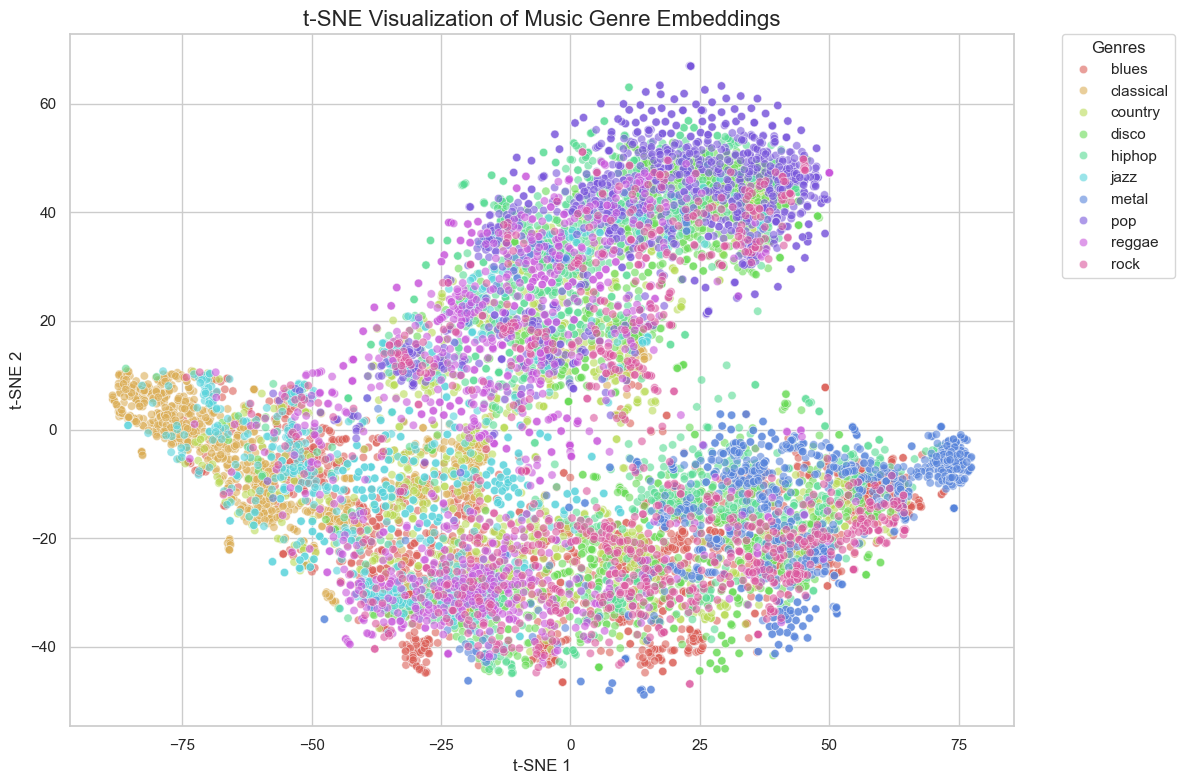

In [33]:
# Flatten input for t-SNE
X_flat = X.reshape(X.shape[0], -1)

# Run t-SNE on entire dataset
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_2d = tsne.fit_transform(X_flat)

# Use all labels
y_2d = y

# Reverse genre_to_index to get index_to_genre
index_to_genre = {v: k for k, v in genre_to_index.items()}
genre_labels = [index_to_genre[i] for i in y_2d]

# Plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

palette = sns.color_palette("hls", len(genre_to_index))  # 10-color palette

scatter = sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=genre_labels,
    palette=palette,
    legend='full',
    alpha=0.6
)

plt.title("t-SNE Visualization of Music Genre Embeddings", fontsize=16)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

## CNN Model & Training

In [34]:
def build_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.001),
                            input_shape=input_shape))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (2, 2), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Build and compile
model = build_model((130, 13, 1), len(combined_genres))

@register_keras_serializable()
def top_3_accuracy(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', top_3_accuracy]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Compute class weights based on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights applied:", class_weights_dict)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    class_weight=class_weights_dict
)

# Print model summary
model.summary()

Class weights applied: {0: 1.0080808080808081, 1: 1.0055415617128463, 2: 0.9844636251541307, 3: 0.9930348258706467, 4: 1.047769028871391, 5: 0.9967540574282148, 6: 1.010632911392405, 7: 0.9942714819427149, 8: 0.9967540574282148, 9: 0.9665859564164649}
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.2989 - loss: 2.5000 - top_3_accuracy: 0.5952 - val_accuracy: 0.4362 - val_loss: 1.8199 - val_top_3_accuracy: 0.8287 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4535 - loss: 1.8605 - top_3_accuracy: 0.7995 - val_accuracy: 0.4422 - val_loss: 1.8641 - val_top_3_accuracy: 0.8162 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5044 - loss: 1.7071 - top_3_accuracy: 0.8294 - val_accuracy: 0.5318 - val_loss: 1.6285 - val_top_3_accuracy: 0.8403 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5306 - loss: 1.5932 - top_3_accuracy: 0.8583 - val_accuracy: 0.5053 - val_loss: 1.7861 - val_top_3_accuracy: 0.8408 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5463 - loss: 1.5595 - top_3_accuracy: 0.8636 - val_accuracy: 0.5583 - val_loss: 1.6591 - val_top_3_accuracy: 0.8423 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 130, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 65, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 65, 7, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 65, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 65, 7, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 33, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 33, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 33, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 33, 4, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 17, 2, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 17, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       557,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,832,352 (6.99 MB)

 Trainable params: 610,634 (2.33 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,221,270 (4.66 MB)

## Evaluation

In [35]:
# Evaluate
loss, acc, top3_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")
print(f"Top-3 Accuracy: {top3_acc:.2f}")

# Save model
model.save("../model/genre_classifier_cnn.keras")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8364 - loss: 0.8751 - top_3_accuracy: 0.9692
Test Accuracy: 0.83
Top-3 Accuracy: 0.97


## Moving Average Smoothing

In [36]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

## Visualize Accuracy and Loss

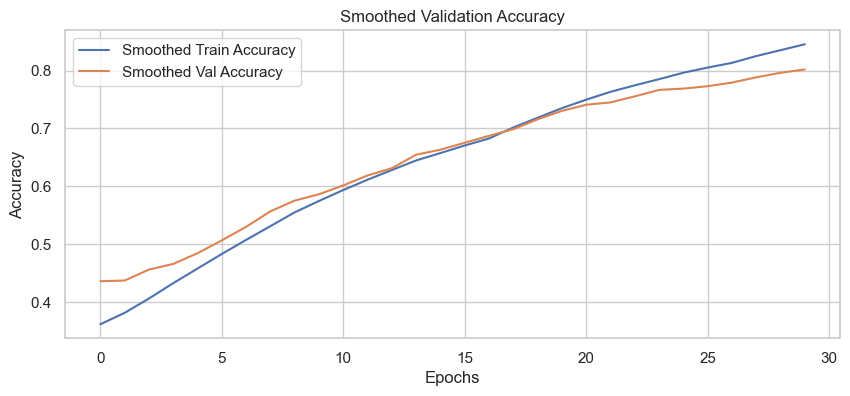

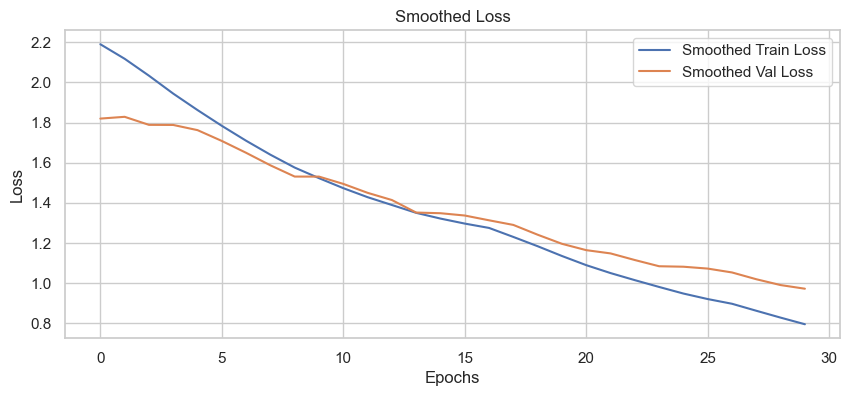

In [37]:
# Raw data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Smooth curves
smooth_acc = smooth_curve(acc)
smooth_val_acc = smooth_curve(val_acc)
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(smooth_acc, label='Smoothed Train Accuracy')
plt.plot(smooth_val_acc, label='Smoothed Val Accuracy')
plt.title('Smoothed Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(smooth_loss, label='Smoothed Train Loss')
plt.plot(smooth_val_loss, label='Smoothed Val Loss')
plt.title('Smoothed Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


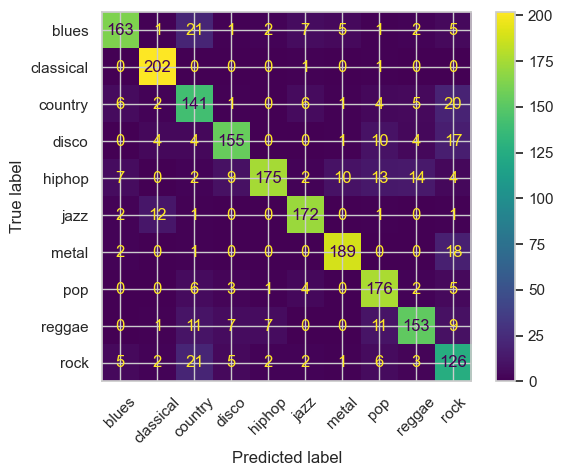

In [38]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=combined_genres).plot(xticks_rotation=45)